In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# ! pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
from ray import tune
from ray.tune.schedulers import ASHAScheduler

# from pycox.models import CoxPH
# from pycox.evaluation import EvalSurv

os.chdir("../")
from pycox.models.cox import CoxPH, CoxPHStratified
from pycox.evaluation.eval_surv import EvalSurv, EvalSurvStratified
from scr.utils import *
from scr.runDeepSurvModels import *

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Optuna

In [17]:
import optuna

### Network Setup

In [ ]:
from abc import ABC, abstractmethod
import optuna

def parse_hyperparameters(trial, config=None):
    """
    Convert a dictionary of hyperparameter ranges into Optuna-compatible format.
    
    Args:
    - trial (optuna.trial.Trial): The Optuna trial object to sample parameters from.
    - hyperparam_dict (dict): A dictionary with hyperparameter names as keys. Values should be a dictionary specifying the type of parameter ('int', 'float', or 'categorical')
      and the range or choices.
      
    Returns:
    - dict: A dictionary of sampled hyperparameters compatible with the given ranges.
    """
    # config = self.hyperparameters if config is None else config
    params = {}
    for param_name, param_info in config.items():
        param_type = param_info.get("type")
        if param_type == "int":
            params[param_name] = trial.suggest_int(param_name, param_info["low"], param_info["high"])
        elif param_type == "float":
            params[param_name] = trial.suggest_float(param_name, param_info["low"], param_info["high"], log=param_info.get("log", False))
        elif param_type == "categorical":
            params[param_name] = trial.suggest_categorical(param_name, param_info["choices"])
        else:
            raise ValueError(f"Unsupported hyperparameter type: {param_type}")
    return params

class DeepSurvPipeline(ABC):
    def __init__(self, train_df, test_df, 
                time_col='time', status_col='status',
                dataName=None, hyperparameters=None, random_state=42):
        self.train_df=train_df
        self.test_df=test_df
        self.n = train_df.shape[0]
        self.time_col = time_col
        self.status_col = status_col
        self.dataName = dataName
        self.hyperparameters = hyperparameters
        self.random_state = random_state
        self.model = None
        self.modelString = 'deepsurv-torch'
    
    def _preprocess_data(self, df):
        """Use StandardScaler() to transform input miRNA data.
        Return transformed features and labels (survival time and censor status) separately.
        """
        survival_cols = [self.time_col, self.status_col]
        covariate_cols = [col for col in df.columns if col not in survival_cols]
        standardize = [([col], StandardScaler()) for col in covariate_cols]
        x_mapper = DataFrameMapper(standardize)

        # transform features (miRNA expression)
        x = x_mapper.fit_transform(df[covariate_cols]).astype('float32')
        # prepare labels (survival data)
        get_target = lambda df: (df[self.time_col].values, df[self.status_col].values)
        y = get_target(df)
        
        return x, y
    
    def train_mlp(self, train_df, val_df, params, patience, min_delta, verbose=False, is_tuning=False):
        """Training function that works for both tuning and main training.

        Args:
            x_train (pandas DataFrame): _description_
            y_train (pandas DataFrame): _description_
            params (dictionary): neural network training parameters
                - 'batch_size': batch size
                - 'epochs': number of training epochs
                - 'num_nodes': hidden layer size
                - 'learning_rate'
                - 'dropout'
                - ...
        """
        # Set hyperparameters with default values
        num_nodes = params.get("num_nodes", [32, 32])           # Default to [32, 32] if not provided
        dropout = params.get("dropout", 0.2)                    # Default dropout rate
        learning_rate = params.get("learning_rate", 1e-3)       # Default learning rate
        batch_size = params.get("batch_size", 32)               # Default batch size
        epochs = params.get("epochs", 100)                      # Default number of epochs
        batch_norm = params.get("batch_norm", True)             # Default batch normalization
        output_bias = params.get("output_bias", True)           # Default output bias
        
        # Prepare data 
        x_train, y_train = self._preprocess_data(train_df)
        val = self._preprocess_data(val_df)
        x_val, y_val = val
        input_size = x_train.shape[1]
        output_size = 1
        
        # =================== Build Neural Net ===================
        ## define network
        net = tt.practical.MLPVanilla(in_features=input_size,
                                    out_features=output_size,
                                    num_nodes=num_nodes,
                                    dropout=dropout, 
                                    batch_norm=batch_norm,
                                    output_bias=output_bias)
        # define optimizer 
        optimizer = tt.optim.Adam(weight_decay=0.01)
        model = CoxPH(net, optimizer)
        model.optimizer.set_lr(learning_rate)

        # =================== Train Model =====================
        callbacks = [tt.callbacks.EarlyStopping(patience=patience, min_delta=min_delta)]
        
        start = time.time() # Record iteration start time
        log = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks, 
                        verbose=verbose,
                        val_data=val,
                        val_batch_size=batch_size
                        )
        stop = time.time() # Record time when training finished
        duration = round(stop - start, 2)
        
        # =================== Evaluation ===================
        _ = model.compute_baseline_hazards()
        val_surv = model.predict_surv_df(x_val)
        val_c_index  = EvalSurv(val_surv, y_val[0], y_val[1], censor_surv='km').concordance_td() 
        
        tr_surv = model.predict_surv_df(x_train)
        tr_c_index  = EvalSurv(tr_surv, y_train[0], y_train[1], censor_surv='km').concordance_td() 
        
        if not is_tuning:
            self.model = model
            self.optimizer = optimizer
            
        return duration, tr_c_index, val_c_index
    
    
    def _objective(self, trial, train_df, config, n_splits=5):
        """Perform K-Fold CV and return the average validation loss across folds.""" 
        
        # Define search space
        self.hyperparameters = config if config is not None else self.hyperparameters
        if self.hyperparameters is None:
            config = {
                "num_nodes": trial.suggest_categorical("num_nodes", [[32, 32], [16, 16]]),
                "dropout": trial.suggest_float("dropout", 0.1, 0.5),
                "learning_rate": trial.suggest_loguniform("learning_rate", 1e-5, 1e-3),
                "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
                "epochs": trial.suggest_int("epochs", 10, 50)  
            }
        else:
            config = parse_hyperparameters(trial, config=self.hyperparameters)

        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        val_c_indexes = []

        for train_index, val_index in kf.split(train_df, train_df[self.status_col]):
            tr_df, val_df = train_df.iloc[train_index,:], train_df.iloc[val_index,:]

            # Train and evaluate on the current fold -- validation score
            *_, val_c_index = self.train_mlp(tr_df, val_df,
                                            config=config,
                                            patience=10, min_delta=1e-2,
                                            verbose=False,
                                            is_tuning=True)
            val_c_indexes.append(val_c_index)
        
        c_index=np.mean(val_c_indexes)
        return c_index
    
    
    def tune_hyperparameters(self, train_df, config=None, n_splits=5, n_trials=20):
        """Method to perform hyperparameter tuning with K-Fold CV."""
        # Create an Optuna study for hyperparameter optimization
        study = optuna.create_study(direction='maximize')
        
        # Optimize the study using the objective function
        study.optimize(lambda trial: self._objective(trial,
                                                    train_df=train_df,
                                                    config=config,
                                                    n_splits=n_splits),
                    n_trials=n_trials)
        
        # Save the best hyperparameters
        self.best_params = study.best_params
        print(f"Best trial parameters: {self.best_params}")
        
        
    def train_with_best_params(self, val_size=0.2, 
                            params=None, 
                            patience=25, min_delta=1e-2,
                            verbose=True, print_scores=False):
        """
        Args:
            subset (_type_): _description_
            batch_sizes (_type_): _description_
            val_size (float, optional): _description_. Defaults to 0.2.
            kwargs (_type_, optional): _description_. Defaults to None.
            time_col (str, optional): _description_. Defaults to 'time'.
            status_col (str, optional): _description_. Defaults to 'status'.
            verbose (bool, optional): _description_. Defaults to True.
            print_scores (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        if params is None and self.best_params is None:
            raise ValueError("No hyperparameters found. Run tune_hyperparameters() first or define them manually.")
        elif params is None:
            params = self.best_params
        
        # ===================== Prepare Data =======================
        tr_df, val_df = train_test_split(self.train_df, 
                                        test_size=val_size,
                                        shuffle=True, random_state=self.random_state,
                                        stratify=self.train_df[self.status_col])
        
        # ===================== Train Model =====================
        duration, train_c, _ = self.train_mlp(tr_df, val_df, params=params, 
                                            patience=patience, min_delta=min_delta,
                                            verbose=verbose, is_tuning=False)

        # ===================== Evaluation =====================
        x_test, y_test = self._preprocess_data(self.test_df)
        te_surv = self.model.predict_surv_df(x_test)
        test_c  = EvalSurv(te_surv, y_test[0], y_test[1], censor_surv='km').concordance_td()
        
        if print_scores:
            print(f"N={self.n} Training time ({duration}s): Train C-Index: {round(train_c,3)} | Test C-index: {round(test_c,3)}")
            
        return duration, train_c, test_c


In [23]:
## Parameter setup
# Load data
folder = 'linear'
keywords = ['moderate', "latest", 'RW']
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.2)

print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")


Training data dimensions: (8000, 1035)
Testing data dimensions:  (2000, 1035)


In [32]:
hyperparams = {
    # "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "num_nodes": {"type": "categorical", "choices": [[32,32], [16,16]]},
    "dropout": {"type": "categorical", "choices": [0.1,0.5]},
}


In [33]:
ds = DeepSurvPipeline(train_df, test_df, hyperparameters=hyperparams)
ds.tune_hyperparameters(train_df)

[I 2024-11-15 12:29:30,052] A new study created in memory with name: no-name-8c0f5f5e-0899-4a05-8d75-3f3be3249446
/home/nfs/dengy/dl-env/lib/python3.8/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [32, 32] which is of type list.
  warnings.warn(message)
/home/nfs/dengy/dl-env/lib/python3.8/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [16, 16] which is of type list.
  warnings.warn(message)
[W 2024-11-15 12:29:30,088] Trial 0 failed with parameters: {'num_nodes': [16, 16], 'dropout': 0.1} because of the following error: AttributeError("'DeepSurvPipeline' object has no attribute '_train_mlp'").
Traceback (most recent call last):
  File "/home/nfs/dengy/dl-env/lib/python3.8/site-packages/optuna/study/_optimize.py", lin

AttributeError: 'DeepSurvPipeline' object has no attribute '_train_mlp'

## Ray Tune
### Network Setup

In [4]:
def to_tune_config(hyperparams):
    """
    Convert a normal dictionary of hyperparameter values to Ray Tune-compatible formats.

    Args:
        hyperparams (dict): Dictionary of hyperparameters with values as single values, ranges, or lists. Examples:

    Returns:
        dict: Ray Tune-compatible search space.
    """
    if hyperparams is None:
        raise ValueError("No hyperparameters given. Input parameter values to convert into Tune compatible format.")

    tune_config = {}
    for key, value in hyperparams.items():
        # Check if value is a list: Use tune.choice
        if isinstance(value, list):
            tune_config[key] = tune.choice(value)
        
        # Check if value is a tuple with two values: Use tune.uniform or tune.randint
        elif isinstance(value, tuple) and len(value) == 2:
            if all(isinstance(v, int) for v in value):  # Integers: use randint
                tune_config[key] = tune.randint(value[0], value[1])
            else:  # Floats: use uniform
                tune_config[key] = tune.uniform(value[0], value[1])
        
        # Check if value is a tuple with "log" indicator: Use tune.loguniform
        elif isinstance(value, tuple) and len(value) == 3 and value[2] == "log":
            tune_config[key] = tune.loguniform(value[0], value[1])
        
        # Single value: Keep as-is (constant)
        else:
            tune_config[key] = value

    return tune_config

In [10]:
from abc import ABC, abstractmethod

class DeepSurvPipeline(ABC):
    def __init__(self, train_df, test_df, 
                time_col='time', status_col='status',
                dataName=None, hyperparameters=None, random_state=42):
        self.train_df=train_df
        self.test_df=test_df
        self.n = train_df.shape[0]
        self.time_col = time_col
        self.status_col = status_col
        self.dataName = dataName
        self.hyperparameters = hyperparameters
        self.random_state = random_state
        self.model = None
        self.modelString = 'deepsurv-torch'
    
    def _preprocess_data(self, df):
        """Use StandardScaler() to transform input miRNA data.
        Return transformed features and labels (survival time and censor status) separately.
        """
        survival_cols = [self.time_col, self.status_col]
        covariate_cols = [col for col in df.columns if col not in survival_cols]
        standardize = [([col], StandardScaler()) for col in covariate_cols]
        x_mapper = DataFrameMapper(standardize)

        # transform features (miRNA expression)
        x = x_mapper.fit_transform(df[covariate_cols]).astype('float32')
        # prepare labels (survival data)
        get_target = lambda df: (df[self.time_col].values, df[self.status_col].values)
        y = get_target(df)
        
        return x, y
    
    def _train_mlp(self, train_df, val_df, config, patience, min_delta, verbose=False, is_tuning=False):
        """Training function that works for both tuning and main training.

        Args:
            x_train (pandas DataFrame): _description_
            y_train (pandas DataFrame): _description_
            config (dictionary): neural network training parameters
                - 'batch_size': batch size
                - 'epochs': number of training epochs
                - 'num_nodes': hidden layer size
                - 'learning_rate'
                - 'dropout'
                - ...
        """
        output_size   = 1 
        num_nodes     = [32, 32] if 'num_nodes' not in config.keys() else config['num_nodes']
        batch_norm    = True if 'batch_norm' not in config.keys() else config['batch_norm'] 
        output_bias   = True if 'output_bias' not in config.keys() else config['output_bias']
        dropout       = 0.2 if 'dropout' not in config.keys() else config['dropout']
        learning_rate = 1e-3 if 'learning_rate' not in config.keys() else config['learning_rate']
        batch_size    = 32 if 'batch_size' not in config.keys() else config['batch_size']
        epochs        = 100 if 'epochs' not in config.keys() else config['epochs']
        
        # Prepare data 
        x_train, y_train = self._preprocess_data(train_df)
        val = self._preprocess_data(val_df)
        x_val, y_val = val
        input_size = x_train.shape[1]

        
        # =================== Build Neural Net ===================
        ## define network
        net = tt.practical.MLPVanilla(in_features=input_size,
                                    out_features=output_size,
                                    num_nodes=num_nodes,
                                    dropout=dropout, 
                                    batch_norm=batch_norm,
                                    output_bias=output_bias)
        # define optimizer 
        optimizer = tt.optim.Adam(weight_decay=0.01)
        model = CoxPH(net, optimizer)
        model.optimizer.set_lr(learning_rate)

        # =================== Train Model =====================
        callbacks = [tt.callbacks.EarlyStopping(patience=patience, min_delta=min_delta)]
        
        start = time.time() # Record iteration start time
        log = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        callbacks=callbacks, 
                        verbose=False if is_tuning else verbose, # print training steps
                        val_data=val, val_batch_size=batch_size
                        )
        stop = time.time() # Record time when training finished
        duration = round(stop - start, 2)
        
        # =================== Evaluation ===================
        _ = model.compute_baseline_hazards()
        val_surv = model.predict_surv_df(x_val)
        val_c_index  = EvalSurv(val_surv, y_val[0], y_val[1], censor_surv='km').concordance_td() 
        
        tr_surv = model.predict_surv_df(x_train)
        tr_c_index  = EvalSurv(tr_surv, y_train[0], y_train[1], censor_surv='km').concordance_td() 
        
        if not is_tuning:
            self.model = model
            self.optimizer = optimizer
            
        return duration, tr_c_index, val_c_index
    
    
    def _objective_with_cv(self, train_df, config, n_splits):
        """Perform K-Fold CV and return the average validation loss across folds.""" 
                
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        val_c_indexes = []

        for train_index, val_index in kf.split(train_df, train_df[self.status_col]):
            tr_df, val_df = train_df.iloc[train_index,:], train_df.iloc[val_index,:]

            # Train and evaluate on the current fold -- validation score
            *_, val_c_index = self._train_mlp(tr_df, val_df,
                                            config=config,
                                            patience=10, min_delta=1e-2,
                                            verbose=False,
                                            is_tuning=True)
            val_c_indexes.append(val_c_index)

        # Calculate average validation c index score across folds
        tune.report(c_index=np.mean(val_c_indexes))
    
    
    def tune_hyperparameters(self, train_df,
                            config=None, n_splits=5,
                            num_samples=10, max_t=20, grace_period=1,
                            n_cpu=2, n_gpu=0):
        """Method to perform hyperparameter tuning with K-Fold CV."""
        
        # Define search space
        self.hyperparameters = config if config is not None else self.hyperparameters
        if self.hyperparameters is None:
            config = {
                "num_nodes": tune.choice([[32, 32], [16, 16]]),
                "dropout": tune.choice([0.1, 0.5]),
                "learning_rate": tune.loguniform(1e-5, 1e-3),
                "epochs": tune.choice([20]),  # Can also tune epochs if desired
                "batch_size": tune.choice([16, 32, 64])  # Optional: tune batch size
            }
        else:
            config = to_tune_config(self.hyperparameters)

        # Run tuning with the cross-validation objective
        scheduler = ASHAScheduler(metric="c_index", 
                                mode="max", 
                                max_t=max_t, 
                                grace_period=grace_period)
        tuner = tune.run(
            lambda cfg: self._objective_with_cv(train_df, cfg, n_splits=n_splits),
            config=config,
            scheduler=scheduler,
            num_samples=num_samples,
            resources_per_trial={"cpu": n_cpu, "gpu": n_gpu}
        )
        
        # Save the best hyperparameters
        self.best_params = tuner.get_best_config(metric="c_index", mode='max')
        print(f"Best trial parameters: {self.best_params.config}")
        
        
    def train_with_best_params(self, val_size=0.2, 
                            kwargs=None, 
                            patience=25, min_delta=1e-2,
                            verbose=True, print_scores=False):
        """
        Args:
            subset (_type_): _description_
            batch_sizes (_type_): _description_
            val_size (float, optional): _description_. Defaults to 0.2.
            kwargs (_type_, optional): _description_. Defaults to None.
            time_col (str, optional): _description_. Defaults to 'time'.
            status_col (str, optional): _description_. Defaults to 'status'.
            verbose (bool, optional): _description_. Defaults to True.
            print_scores (bool, optional): _description_. Defaults to False.

        Returns:
            _type_: _description_
        """
        if kwargs is None and self.best_params is None:
            raise ValueError("No hyperparameters found. Run tune_hyperparameters() first or define them manually.")
        elif kwargs is None:
            kwargs = self.best_params
        
        # ===================== Prepare Data =======================
        tr_df, val_df = train_test_split(self.train_df, 
                                        test_size=val_size,
                                        shuffle=True, random_state=self.random_state,
                                        stratify=self.train_df[self.status_col])
        
        # ===================== Train Model =====================
        duration, train_c, _ = self._train_mlp(tr_df, val_df, config=kwargs, 
                                            patience=patience, min_delta=min_delta,
                                            verbose=verbose, is_tuning=False)

        # ===================== Evaluation =====================
        x_test, y_test = self._preprocess_data(self.test_df)
        te_surv = self.model.predict_surv_df(x_test)
        test_c  = EvalSurv(te_surv, y_test[0], y_test[1], censor_surv='km').concordance_td()
        
        if print_scores:
            print(f"N={self.n} Training time ({duration}s): Train C-Index: {round(train_c,3)} | Test C-index: {round(test_c,3)}")
            
        return duration, train_c, test_c
    
    
    def write(self, model_results, out_dir=None, fileName='model.results.txt'):
        out_dir=os.path.join('models', self.dataName, self.modelString) if out_dir is None else out_dir
        os.makedirs(out_dir, exist_ok=True)
        
        # save results as txt or csv file
        if 'txt' in fileName:
            model_results.to_csv(os.path.join(out_dir,fileName), sep='\t')
        elif 'csv' in fileName:
            model_results.to_csv(os.path.join(out_dir,fileName), index=False)
        else:
            print('Please specify a file name with either a txt or csv extension.')  


In [6]:
## Function to plot simulated data -- later add to utils!!
def plot_simulation_data(train_df, test_df):
    # observe data
    print("Event rate in train set: %f" % (sum(train_df['status']==1) / train_df.shape[0]))
    print("Event rate in test set: %f" %  (sum(test_df['status']==1) / test_df.shape[0]))
    print('Survival time distribution:')
    _, ax = plt.subplots(figsize=(3,3))
    ax.hist(train_df['time'], label='train')
    # ax.hist(val_df['time'],   label='val', alpha=.8)
    ax.hist(test_df['time'], label='test', alpha=0.6)
    ax.legend(fontsize=12)
    plt.show()

### Parameter Setup

In [6]:
# subset = [50, 500, 1000, 2000, 5000, 8000]
# batch_sizes = [8, 16, 16, 32, 64, 128] #[8, 16, 16, 32, 32, 64]

parameters = {
    'num_nodes': [32, 32],
    'batch_norm': True,
    'output_bias': True,
    'dropout': 0.2,
    'batch_size': 64,
    'learning_rate': 1e-3
}

hyperparams =  {
        "num_nodes": [[32, 32], [16, 16]],       # list for tune.choice
        "dropout": [0.1, 0.5]                    # tuple for tune.uniform
        # "learning_rate": (1e-5, 1e-3, "log"),  # tuple with "log" for tune.loguniform
        # "batch_size": [32, 64]                 # single value, unchanged
    }
to_tune_config(hyperparams)

{'num_nodes': <ray.tune.search.sample.Categorical at 0x7f4c15d130a0>,
 'dropout': <ray.tune.search.sample.Categorical at 0x7f4c15d134c0>}

In [7]:
# Load data
folder = 'linear'
keywords = ['moderate', "latest", 'RW']
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords, test_size=0.2)

print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")

Training data dimensions: (8000, 1035)
Testing data dimensions:  (2000, 1035)


In [ ]:
import ray
ray.shutdown()
ray.init()

2024-11-15 09:47:29,805	INFO worker.py:1752 -- Started a local Ray instance.


Python version:,3.8.10
Ray version:,2.10.0


In [15]:
hyperparams = {"num_nodes": [[32, 32], [16, 16]]}
ds = DeepSurvPipeline(train_df, test_df, hyperparameters=hyperparams)
ds.tune_hyperparameters(train_df, n_cpu=2)
ds.best_params
# ds.train_with_best_params(subset, time_col='t', status_col='delta',
#                             batch_sizes=[8],
#                             patience=25, min_delta=1e-2, 
#                             kwargs=parameters, verbose=False, print_scores=True)

2024-11-15 09:52:20,493	INFO tune.py:613 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-11-15 09:52:20,704	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


2024-11-15 09:55:28,149	WARNING tune.py:229 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-11-15 09:55:28,162	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/home/nfs/dengy/ray_results/lambda_2024-11-15_09-52-20' in 0.0114s.
2024-11-15 09:55:28,186	INFO tune.py:1048 -- Total run time: 187.69 seconds (187.44 seconds for the tuning loop).
2024-11-15 09:55:28,188	WARNING tune.py:1063 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2024-11-15 09:55:28,207	WARNING experiment_analysis.py:190 -- Failed to fetch metrics for 10 trial(s):
- lambda_3751e_00000: FileNotFoundError('Could not fetch metrics for lambda_3751e_00000: both result.json and progress.csv were not found at /home/nfs/dengy/ray_results/lambda_2024-11-15_09-52-20/

AttributeError: 'NoneType' object has no attribute 'config'

In [16]:
ray.nodes()

[{'NodeID': '78e52435cfefa2a922a80b743333273feeeca1478a097f0c1461ecf6',
  'Alive': True,
  'NodeManagerAddress': '172.26.104.244',
  'NodeManagerHostname': 'omega00',
  'NodeManagerPort': 44215,
  'ObjectManagerPort': 33013,
  'ObjectStoreSocketName': '/tmp/ray/session_2024-11-15_09-47-26_814418_15857/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2024-11-15_09-47-26_814418_15857/sockets/raylet',
  'MetricsExportPort': 54861,
  'NodeName': '172.26.104.244',
  'RuntimeEnvAgentPort': 44570,
  'alive': True,
  'Resources': {'node:__internal_head__': 1.0,
   'node:172.26.104.244': 1.0,
   'CPU': 32.0,
   'memory': 177944412365.0,
   'object_store_memory': 80547605299.0},
  'Labels': {'ray.io/node_id': '78e52435cfefa2a922a80b743333273feeeca1478a097f0c1461ecf6'}}]

# Train on Data with Batch

## TCGA real world data

In [ ]:
brca_clin  = pd.read_csv(os.path.join("data", "batch", "TCGA_miRNA_clinical.csv"))
brca_mirna = pd.read_csv(os.path.join("data", "batch", "TCGA-BRCA-3.csv"), index_col=0)

brca_clin = brca_clin.rename(columns={'bcr_patient_barcode':'Sample'})

brca = pd.merge(brca_mirna, brca_clin, on='Sample', how = 'left')
brca_df = brca.loc[:, ['days_to_death', 
                       'days_to_last_followup'] +
                    [col for col in brca.columns if 'hsa' in col]]

Number of events: 102
Number of censored cases: 912


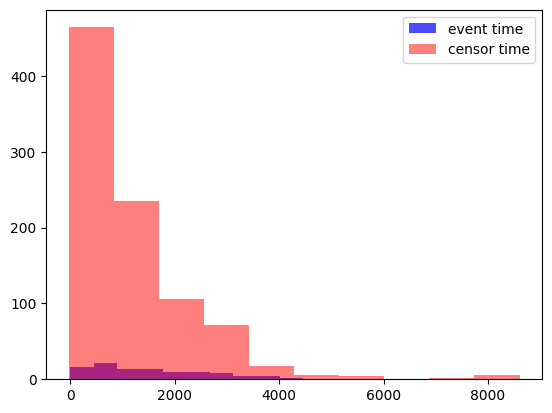

In [ ]:
deathtt = brca_df['days_to_death'][~np.isnan(brca_df['days_to_death'])]
censortt = brca_df['days_to_last_followup'][~np.isnan(brca_df['days_to_last_followup'])]
print("Number of events: %d" % len(deathtt))
print("Number of censored cases: %d" %len(censortt))
plt.hist(deathtt, color='b', label='event time', alpha=0.7)
plt.hist(censortt, color='r', label='censor time', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
# get censoring status and survival time
brca_df['status'] = [int(i) for i in ~np.isnan(brca_df['days_to_death'])]

brca_df['time'] = brca_df['days_to_death']
brca_df['time'][np.isnan(brca_df['time'])] = brca_df['days_to_last_followup'][np.isnan(brca_df['time'])]

/tmp/ipykernel_777201/4163331497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brca_df['time'][np.isnan(brca_df['time'])] = brca_df['days_to_last_followup'][np.isnan(brca_df['time'])]


In [ ]:
brca_df = brca_df.drop(columns=['days_to_death',"days_to_last_followup"])
brca_df = brca_df.dropna().reset_index(drop=True)

In [ ]:
print("Event rate in the TCGA BRCA data: %f" % (sum(brca_df['status']) / brca_df.shape[0]))

Event rate in the TCGA BRCA data: 0.100592


In [ ]:
learning_rate = 1e-4
parameters = {
    'num_nodes': [64, 32, 32],
    'out_features': 1,
    'batch_norm' :True,
    'dropout' : 0.2,
    'output_bias' : True
}

In [ ]:
train_df, test_df = train_test_split(brca_df, test_size=0.2, random_state=42, stratify=brca_df['status'])

subset = [train_df.shape[0]]
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName="tcga-brca")
ds_results = ds.run_deepsurv(subset,
                            batch_sizes=[32],
                            patience=25, min_delta=1e-3,
                            kwargs=parameters, verbose=True, print_scores=False)
ds_results

0:	[0s / 0s],	
1:	[0s / 0s],	
2:	[0s / 0s],	
3:	[0s / 0s],	
4:	[0s / 0s],	
5:	[0s / 0s],	
6:	[0s / 0s],	
7:	[0s / 0s],	
8:	[0s / 0s],	
9:	[0s / 0s],	
10:	[0s / 0s],	
11:	[0s / 0s],	
12:	[0s / 0s],	
13:	[0s / 0s],	
14:	[0s / 0s],	
15:	[0s / 1s],	
16:	[0s / 1s],	
17:	[0s / 1s],	
18:	[0s / 1s],	
19:	[0s / 1s],	
20:	[0s / 1s],	
21:	[0s / 1s],	
22:	[0s / 1s],	
23:	[0s / 1s],	
24:	[0s / 1s],	


/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

,n train,train time,train score,test score
0,811,1.68,0.437989,0.51035


## Simulated data with batch

In [20]:
# load simulated data
df_withBatch = pd.read_csv(os.path.join("data","batch", "demo_sim_withBatch.csv")).iloc[:, 1:]
df_noBatch   = pd.read_csv(os.path.join("data","batch", "demo_sim_noBatch.csv")).iloc[:, 1:]

df_withBatch.head()

,t,delta,A_25_P00010019,A_25_P00010020,A_25_P00010021,A_25_P00010023,A_25_P00010041,A_25_P00010042,A_25_P00010043,A_25_P00010044,...,A_25_P00016269,A_25_P00016270,A_25_P00016271,A_38_P00018874,A_38_P00018875,A_38_P00018876,A_38_P00018877,A_38_P00018878,A_38_P00018879,batch_id
0,54.77,0,5.414510,5.361662,5.310293,5.324175,5.303017,5.280794,5.155670,5.133808,...,5.464329,5.540626,5.496476,5.476537,5.370435,5.593264,5.664620,5.554928,5.877363,1
1,9.63,1,5.645660,5.628909,5.428349,5.476566,5.651610,5.433626,5.502592,5.512356,...,6.003386,6.206899,6.001569,5.825270,5.861964,6.057292,6.187139,6.776756,7.332764,1
2,35.93,0,5.556705,5.498588,5.415355,5.568460,5.446503,5.393021,5.474867,5.342807,...,5.669618,5.745632,5.669056,5.699790,5.704279,5.976060,5.899931,6.011728,6.423470,1
3,71.84,0,5.107029,4.998545,5.001954,4.976329,5.009803,4.983482,4.873145,4.878836,...,5.203232,5.211459,5.179419,4.940771,4.868911,5.083392,5.119356,5.026625,5.225131,1
4,20.52,1,5.715634,5.554129,5.560682,5.429897,5.525073,5.539028,5.455037,5.461786,...,6.043570,6.009590,6.041434,5.494935,5.562034,5.585995,5.702457,5.546448,5.863067,1


In [ ]:
train_df, test_df = train_test_split(df_withBatch, test_size=0.2, random_state=42, stratify=df_withBatch['delta'])

subset = [train_df.shape[0]]
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName="with-batch")
ds_results = ds.run_deepsurv(subset, time_col='t', status_col='delta',
                            batch_sizes=[8],
                            patience=25, min_delta=1e-2, 
                            kwargs=parameters, verbose=False, print_scores=True)
ds_results

/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)

N=76 Training time (0.59s): Train C-Index: 0.77 | Test C-index: 0.721


,n train,train time,train score,test score
0,76,0.59,0.769944,0.72093


In [ ]:
train_df, test_df = train_test_split(df_noBatch, test_size=0.2, random_state=42, stratify=df_noBatch['delta'])

subset = [train_df.shape[0]]
ds = DeepSurvPipeline(train_df=train_df, test_df=test_df, dataName="with-batch")
ds_results = ds.run_deepsurv(subset, time_col='t', status_col='delta',
                            batch_sizes=[8],
                            patience=25, min_delta=1e-2, 
                            kwargs=parameters, verbose=True, print_scores=True)

0:	[0s / 0s],		train_loss: 1.4430,	val_loss: 2.2770
1:	[0s / 0s],		train_loss: 1.2151,	val_loss: 1.8226
2:	[0s / 0s],		train_loss: 1.1575,	val_loss: 1.6374
3:	[0s / 0s],		train_loss: 1.1089,	val_loss: 1.5421
4:	[0s / 0s],		train_loss: 1.1016,	val_loss: 1.4289
5:	[0s / 0s],		train_loss: 1.0703,	val_loss: 1.3313
6:	[0s / 0s],		train_loss: 1.0573,	val_loss: 1.3368
7:	[0s / 0s],		train_loss: 1.0322,	val_loss: 1.3628
8:	[0s / 0s],		train_loss: 1.0965,	val_loss: 1.1529
9:	[0s / 0s],		train_loss: 0.9755,	val_loss: 1.1564
10:	[0s / 0s],		train_loss: 1.0619,	val_loss: 1.2399
11:	[0s / 0s],		train_loss: 0.9085,	val_loss: 1.2943
12:	[0s / 0s],		train_loss: 0.9006,	val_loss: 1.3940
13:	[0s / 0s],		train_loss: 0.8678,	val_loss: 1.2190
14:	[0s / 0s],		train_loss: 0.8291,	val_loss: 1.1011
15:	[0s / 0s],		train_loss: 0.9967,	val_loss: 1.1122
16:	[0s / 0s],		train_loss: 0.8468,	val_loss: 1.2879
17:	[0s / 0s],		train_loss: 0.8151,	val_loss: 1.4811
18:	[0s / 0s],		train_loss: 0.9106,	val_loss: 1.2335
19:

/home/nfs/dengy/dl-env/lib/python3.8/site-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs)